In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rishitmurarka/gym-exercises-dataset")

print("Path to dataset files:", path)

/home/advay/Desktop/gym/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/advay/.cache/kagglehub/datasets/rishitmurarka/gym-exercises-dataset/versions/1


In [2]:
import pandas as pd

In [4]:
gym=pd.read_csv(f"{path}/gym_exercise_dataset.csv")
gym


,Exercise Name,Equipment,Variation,Utility,Mechanics,Force,Preparation,Execution,Target_Muscles,Synergist_Muscles,Stabilizer_Muscles,Antagonist_Muscles,Dynamic_Stabilizer_Muscles,Main_muscle,Difficulty (1-5),Secondary Muscles,parent_id
0,Neck Flexion,Cable,No,Basic or Auxiliary,Isolated,Pull,Sit on bench facing away from middle pulley. P...,Move head away from pulley by bending neck for...,"Sternocleidomastoid,","None,","Rectus Abdominis, Obliques,",NaN,NaN,Neck,2,Sternocleidomastoid,NaN
1,Neck Flexion,Lever (plate loaded),No,Basic or Auxiliary,Isolated,Pull,Sit on seat in machine. Position padded lever ...,Move head forward by flexing neck until chin t...,"Sternocleidomastoid,","None,","Latissimus Dorsi, Deltoid, Posterior, Rhomboid...",NaN,NaN,Neck,2,Sternocleidomastoid,NaN
2,Lateral Neck Flexion,Lever (plate loaded),No,Auxiliary,Isolated,Pull,Sit on seat in machine with feet apart . Pos...,Move head down to side by laterally flexing ne...,"Sternocleidomastoid,","Splenius, Erector Spinae, Levator Scapulae, Tr...","Latissimus Dorsi, Pectoralis Major, Sternal, P...",NaN,NaN,Neck,2,"Sternocleidomastoid, Levator Scapulae",NaN
3,Neck Flexion,Lever (selectorized),No,Basic or Auxiliary,Isolated,Pull,Sit on seat in machine. Position padded lever ...,Move head forward by flexing neck until chin t...,"Sternocleidomastoid,","None,","Latissimus Dorsi, Deltoid, Posterior, Rhomboid...",NaN,NaN,Neck,2,Sternocleidomastoid,NaN
4,Lateral Neck Flexion,Lever (selectorized),No,Auxiliary,Isolated,Pull,Sit on seat in machine with feet apart. Positi...,Move head down to side by laterally flexing ne...,"Sternocleidomastoid,","Splenius, Erector Spinae, Levator Scapulae, Tr...","Latissimus Dorsi, Pectoralis Major, Sternal, P...",NaN,NaN,Neck,2,"Sternocleidomastoid, Levator Scapulae",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,Lying Reverse Calf Press,Sled,No,Basic or Auxiliary,Isolated,Pull,Position sled away from platform. Lie supine o...,Pull forefoot back toward body as far as possi...,"Tibialis Anterior,","None,","No significant stabilizers,",NaN,NaN,Calves,2,Tibialis Anterior,NaN
613,Seated Reverse Calf Press,Sled,No,Basic or Auxiliary,Isolated,Pull,Sit on seat and place feet very high on platfo...,Pull forefoot back toward body as far as possi...,"Tibialis Anterior,","None,","No significant stabilizers,",NaN,NaN,Calves,2,Tibialis Anterior,NaN
614,Reverse Calf Raise,Smith,No,Basic or Auxiliary,Isolated,Pull,Position bar upper chest height and place calf...,Pull forefoot of both feet up toward body as f...,"Tibialis Anterior,","None,","No significant stabilizers,",NaN,NaN,Calves,2,Tibialis Anterior,NaN
615,Reverse Calf Raise,Body Weight,No,Basic or Auxiliary,Isolated,Pull,Position heels on forward edge of calf block o...,Pull forefoot of both feet up toward body as f...,"Tibialis Anterior,","None,",NaN,NaN,NaN,Calves,2,Tibialis Anterior,NaN


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

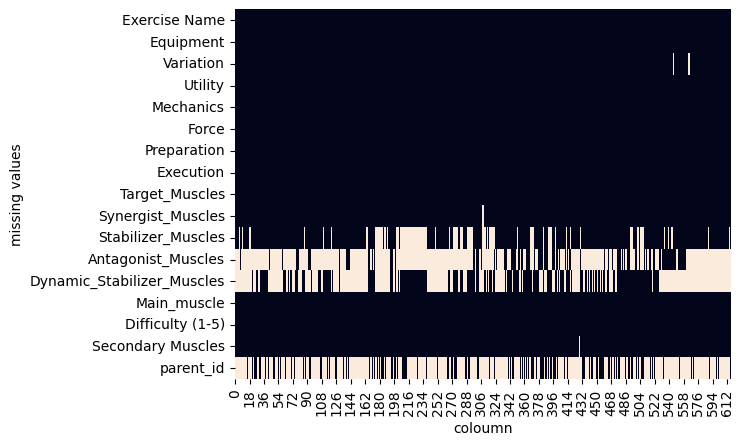

In [6]:
ax=plt.axes()
sns.heatmap(gym.isna().transpose(),cbar=False,ax=ax)

plt.xlabel("coloumn")
plt.ylabel("missing values")
plt.show()

In [7]:

gym.drop(['Stabilizer_Muscles', 'Antagonist_Muscles', 'parent_id'], axis=1, inplace=True)
gym

,Exercise Name,Equipment,Variation,Utility,Mechanics,Force,Preparation,Execution,Target_Muscles,Synergist_Muscles,Dynamic_Stabilizer_Muscles,Main_muscle,Difficulty (1-5),Secondary Muscles
0,Neck Flexion,Cable,No,Basic or Auxiliary,Isolated,Pull,Sit on bench facing away from middle pulley. P...,Move head away from pulley by bending neck for...,"Sternocleidomastoid,","None,",NaN,Neck,2,Sternocleidomastoid
1,Neck Flexion,Lever (plate loaded),No,Basic or Auxiliary,Isolated,Pull,Sit on seat in machine. Position padded lever ...,Move head forward by flexing neck until chin t...,"Sternocleidomastoid,","None,",NaN,Neck,2,Sternocleidomastoid
2,Lateral Neck Flexion,Lever (plate loaded),No,Auxiliary,Isolated,Pull,Sit on seat in machine with feet apart . Pos...,Move head down to side by laterally flexing ne...,"Sternocleidomastoid,","Splenius, Erector Spinae, Levator Scapulae, Tr...",NaN,Neck,2,"Sternocleidomastoid, Levator Scapulae"
3,Neck Flexion,Lever (selectorized),No,Basic or Auxiliary,Isolated,Pull,Sit on seat in machine. Position padded lever ...,Move head forward by flexing neck until chin t...,"Sternocleidomastoid,","None,",NaN,Neck,2,Sternocleidomastoid
4,Lateral Neck Flexion,Lever (selectorized),No,Auxiliary,Isolated,Pull,Sit on seat in machine with feet apart. Positi...,Move head down to side by laterally flexing ne...,"Sternocleidomastoid,","Splenius, Erector Spinae, Levator Scapulae, Tr...",NaN,Neck,2,"Sternocleidomastoid, Levator Scapulae"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,Lying Reverse Calf Press,Sled,No,Basic or Auxiliary,Isolated,Pull,Position sled away from platform. Lie supine o...,Pull forefoot back toward body as far as possi...,"Tibialis Anterior,","None,",NaN,Calves,2,Tibialis Anterior
613,Seated Reverse Calf Press,Sled,No,Basic or Auxiliary,Isolated,Pull,Sit on seat and place feet very high on platfo...,Pull forefoot back toward body as far as possi...,"Tibialis Anterior,","None,",NaN,Calves,2,Tibialis Anterior
614,Reverse Calf Raise,Smith,No,Basic or Auxiliary,Isolated,Pull,Position bar upper chest height and place calf...,Pull forefoot of both feet up toward body as f...,"Tibialis Anterior,","None,",NaN,Calves,2,Tibialis Anterior
615,Reverse Calf Raise,Body Weight,No,Basic or Auxiliary,Isolated,Pull,Position heels on forward edge of calf block o...,Pull forefoot of both feet up toward body as f...,"Tibialis Anterior,","None,",NaN,Calves,2,Tibialis Anterior


In [8]:
gym.drop(['Dynamic_Stabilizer_Muscles'], axis=1, inplace=True)
gym

,Exercise Name,Equipment,Variation,Utility,Mechanics,Force,Preparation,Execution,Target_Muscles,Synergist_Muscles,Main_muscle,Difficulty (1-5),Secondary Muscles
0,Neck Flexion,Cable,No,Basic or Auxiliary,Isolated,Pull,Sit on bench facing away from middle pulley. P...,Move head away from pulley by bending neck for...,"Sternocleidomastoid,","None,",Neck,2,Sternocleidomastoid
1,Neck Flexion,Lever (plate loaded),No,Basic or Auxiliary,Isolated,Pull,Sit on seat in machine. Position padded lever ...,Move head forward by flexing neck until chin t...,"Sternocleidomastoid,","None,",Neck,2,Sternocleidomastoid
2,Lateral Neck Flexion,Lever (plate loaded),No,Auxiliary,Isolated,Pull,Sit on seat in machine with feet apart . Pos...,Move head down to side by laterally flexing ne...,"Sternocleidomastoid,","Splenius, Erector Spinae, Levator Scapulae, Tr...",Neck,2,"Sternocleidomastoid, Levator Scapulae"
3,Neck Flexion,Lever (selectorized),No,Basic or Auxiliary,Isolated,Pull,Sit on seat in machine. Position padded lever ...,Move head forward by flexing neck until chin t...,"Sternocleidomastoid,","None,",Neck,2,Sternocleidomastoid
4,Lateral Neck Flexion,Lever (selectorized),No,Auxiliary,Isolated,Pull,Sit on seat in machine with feet apart. Positi...,Move head down to side by laterally flexing ne...,"Sternocleidomastoid,","Splenius, Erector Spinae, Levator Scapulae, Tr...",Neck,2,"Sternocleidomastoid, Levator Scapulae"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,Lying Reverse Calf Press,Sled,No,Basic or Auxiliary,Isolated,Pull,Position sled away from platform. Lie supine o...,Pull forefoot back toward body as far as possi...,"Tibialis Anterior,","None,",Calves,2,Tibialis Anterior
613,Seated Reverse Calf Press,Sled,No,Basic or Auxiliary,Isolated,Pull,Sit on seat and place feet very high on platfo...,Pull forefoot back toward body as far as possi...,"Tibialis Anterior,","None,",Calves,2,Tibialis Anterior
614,Reverse Calf Raise,Smith,No,Basic or Auxiliary,Isolated,Pull,Position bar upper chest height and place calf...,Pull forefoot of both feet up toward body as f...,"Tibialis Anterior,","None,",Calves,2,Tibialis Anterior
615,Reverse Calf Raise,Body Weight,No,Basic or Auxiliary,Isolated,Pull,Position heels on forward edge of calf block o...,Pull forefoot of both feet up toward body as f...,"Tibialis Anterior,","None,",Calves,2,Tibialis Anterior


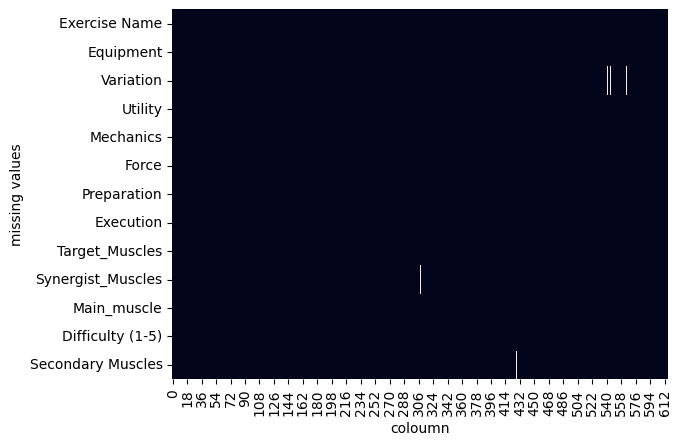

In [9]:
ax=plt.axes()
sns.heatmap(gym.isna().transpose(),cbar=False,ax=ax)

plt.xlabel("coloumn")
plt.ylabel("missing values")
plt.show()

In [10]:
def generate_exercise_description(row):
    return f"""
    Exercise Name: {row['Exercise Name']}
    Equipment: {row['Equipment']}
    Variation: {row['Variation']}
    Utility: {row['Utility']}
    Mechanics: {row['Mechanics']}
    Force: {row['Force']}
    Preparation: {row['Preparation']}
    Execution: {row['Execution']}
    Difficulty (1-5): {row['Difficulty (1-5)']}
    Main Muscle: {row['Main_muscle']}
    Synergist Muscles: {row['Synergist_Muscles']}
    Secondary Muscles: {row['Secondary Muscles']}
    """


In [12]:
gym['llm_entry'] = gym.apply(generate_exercise_description, axis=1)
gym

,Exercise Name,Equipment,Variation,Utility,Mechanics,Force,Preparation,Execution,Target_Muscles,Synergist_Muscles,Main_muscle,Difficulty (1-5),Secondary Muscles,llm_entry
0,Neck Flexion,Cable,No,Basic or Auxiliary,Isolated,Pull,Sit on bench facing away from middle pulley. P...,Move head away from pulley by bending neck for...,"Sternocleidomastoid,","None,",Neck,2,Sternocleidomastoid,\n Exercise Name: Neck Flexion\n Equipme...
1,Neck Flexion,Lever (plate loaded),No,Basic or Auxiliary,Isolated,Pull,Sit on seat in machine. Position padded lever ...,Move head forward by flexing neck until chin t...,"Sternocleidomastoid,","None,",Neck,2,Sternocleidomastoid,\n Exercise Name: Neck Flexion\n Equipme...
2,Lateral Neck Flexion,Lever (plate loaded),No,Auxiliary,Isolated,Pull,Sit on seat in machine with feet apart . Pos...,Move head down to side by laterally flexing ne...,"Sternocleidomastoid,","Splenius, Erector Spinae, Levator Scapulae, Tr...",Neck,2,"Sternocleidomastoid, Levator Scapulae",\n Exercise Name: Lateral Neck Flexion\n ...
3,Neck Flexion,Lever (selectorized),No,Basic or Auxiliary,Isolated,Pull,Sit on seat in machine. Position padded lever ...,Move head forward by flexing neck until chin t...,"Sternocleidomastoid,","None,",Neck,2,Sternocleidomastoid,\n Exercise Name: Neck Flexion\n Equipme...
4,Lateral Neck Flexion,Lever (selectorized),No,Auxiliary,Isolated,Pull,Sit on seat in machine with feet apart. Positi...,Move head down to side by laterally flexing ne...,"Sternocleidomastoid,","Splenius, Erector Spinae, Levator Scapulae, Tr...",Neck,2,"Sternocleidomastoid, Levator Scapulae",\n Exercise Name: Lateral Neck Flexion\n ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,Lying Reverse Calf Press,Sled,No,Basic or Auxiliary,Isolated,Pull,Position sled away from platform. Lie supine o...,Pull forefoot back toward body as far as possi...,"Tibialis Anterior,","None,",Calves,2,Tibialis Anterior,\n Exercise Name: Lying Reverse Calf Press\...
613,Seated Reverse Calf Press,Sled,No,Basic or Auxiliary,Isolated,Pull,Sit on seat and place feet very high on platfo...,Pull forefoot back toward body as far as possi...,"Tibialis Anterior,","None,",Calves,2,Tibialis Anterior,\n Exercise Name: Seated Reverse Calf Press...
614,Reverse Calf Raise,Smith,No,Basic or Auxiliary,Isolated,Pull,Position bar upper chest height and place calf...,Pull forefoot of both feet up toward body as f...,"Tibialis Anterior,","None,",Calves,2,Tibialis Anterior,\n Exercise Name: Reverse Calf Raise\n E...
615,Reverse Calf Raise,Body Weight,No,Basic or Auxiliary,Isolated,Pull,Position heels on forward edge of calf block o...,Pull forefoot of both feet up toward body as f...,"Tibialis Anterior,","None,",Calves,2,Tibialis Anterior,\n Exercise Name: Reverse Calf Raise\n E...


In [17]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document


In [18]:
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [19]:
docs = [
    Document(page_content=row['llm_entry'], metadata={'Main_muscle': row['Main_muscle']})
    for _, row in gym.iterrows()
]

vectorstore = FAISS.from_documents(docs, embedding)


In [50]:
query = "give me some chest and back exercise"
results = vectorstore.similarity_search(query, k=4)

for r in results:
    print(r.page_content)



    Exercise Name: Chest Dip
    Equipment: Band-assisted
    Variation: No
    Utility: Basic or Auxiliary
    Mechanics: Compound
    Force: Push
    Preparation: Lie prone on floor with hands slightly wider than shoulder width. Raise body up off floor by extending arms with body straight. Partner can place weight plate(s) on back if needed.
    Execution: Keeping body straight, lower body to floor by bending arms. Push body up until arms are extended. Repeat.
    Difficulty (1-5): 3
    Main Muscle: Chest
    Synergist Muscles: Pectoralis Major, Clavicular, Deltoid, Anterior, Triceps Brachii, Coracobrachialis, 
    Secondary Muscles: Triceps Brachii, Anterior Deltoid
    

    Exercise Name: Seated Row (no chest pad):  Straight Back
    Equipment: Lever (selectorized)
    Variation: Yes
    Utility: Basic
    Mechanics: Compound
    Force: Pull
    Preparation: Sit on seat and grasp handles with each hand. Place feet on vertically angled platform. Slide hips back with knees slightl

In [81]:
from rapidfuzz import process

# Your canonical list of valid muscles
VALID_MUSCLES = ['Neck', 'Shoulder', 'Upper Arms', 'Forearm', 'Back', 'Chest', 'Hips', 'Thighs', 'Calves']

def correct_muscle_name(user_input, valid_list=VALID_MUSCLES, threshold=80):
    """
    Corrects a possibly misspelled muscle name using fuzzy matching.
    Returns the best match if above the threshold, else None.
    """
    match, score, _ = process.extractOne(user_input, valid_list)
    return match if score >= threshold else None

In [86]:
def parse_query(query: str):
    import spacy
    import re
    nlp = spacy.load("en_core_web_sm")
    
    # Extract number
    number_match = re.search(r'(\d+)', query)
    num_exercises = int(number_match.group(1)) if number_match else 5

    # Tokenize
    doc = nlp(query.lower())
    found_muscles = set()

    for token in doc:
        # Try to correct each token to a valid muscle
        corrected = correct_muscle_name(token.text.capitalize())
        if corrected:
            found_muscles.add(corrected)

    return num_exercises, list(found_muscles)


In [94]:
def get_exercises(query: str, vectorstore):
    num_exercises, muscles = parse_query(query)
    if not muscles:
        return [" No valid muscles found. Try 'Chest', 'Back', etc."]

    per_muscle = max(1, num_exercises // len(muscles))
    all_results = []
    seen = set()

    for muscle in muscles:
        results = vectorstore.similarity_search(f"exercises for {muscle}", k=per_muscle * 2)
        count = 0
        for res in results:
            if res.page_content not in seen and count < per_muscle:
                all_results.append(res)
                seen.add(res.page_content)
                count += 1

    # Fallback if not enough
    if len(all_results) < num_exercises:
        extra_needed = num_exercises - len(all_results)
        fallback = vectorstore.similarity_search(query, k=extra_needed * 2)
        for res in fallback:
            if res.page_content not in seen and len(all_results) < num_exercises:
                all_results.append(res)
                seen.add(res.page_content)

    return [doc.page_content for doc in all_results[:num_exercises]]


In [108]:
query = "give me 3 sholder,back,neck and chest workout"
results = get_exercises(query, vectorstore)

print(f"\n--- Results for: '{query}' ---\n")
for res in results:
    print(res)
    print("-" * 60)



--- Results for: 'give me 3 sholder,back,neck and chest workout' ---


    Exercise Name: Inverted Row:  Feet Elevated
    Equipment: Body Weight
    Variation: Yes
    Utility: Basic or Auxiliary
    Mechanics: Compound
    Force: Pull
    Preparation: Lay on back under fixed horizontal bar. Grasp bar with wide overhand grip. Place back of heels on elevated surface.
    Execution: Keeping body straight, pull body up to bar. Pull shoulders back at top of movement with chest high. Return until arms are extended and shoulders are stretched forward. Repeat.
    Difficulty (1-5): 4
    Main Muscle: Back
    Synergist Muscles: Trapezius, Middle, Trapezius, Lower, Rhomboids, Latissimus Dorsi, Teres Major, Deltoid, Posterior, Infraspinatus, Teres Minor, Brachialis, Brachioradialis, Pectoralis Major, Sternal, 
    Secondary Muscles: Biceps Brachii, Trapezius, Rhomboids
    
------------------------------------------------------------

    Exercise Name: Neck Flexion
    Equipment: Weighted
  

In [80]:
unique_main_muscles = gym['Main_muscle'].unique()
unique_main_muscles

array(['Neck', 'Shoulder', 'Upper Arms', 'Forearm', 'Back', 'Chest',
       'Hips', 'Thighs', 'Calves'], dtype=object)

In [111]:
import streamlit as st

st.title("🏋️ AI Gym Assistant")
user_query = st.chat_input("Ask about workouts...")

if user_query:
    st.chat_message("user").write(user_query)
    with st.chat_message("assistant"):
        results = get_exercises(user_query, vectorstore)
        for r in results:
            st.markdown(r, unsafe_allow_html=True)

2025-07-26 21:40:57.306 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 21:40:57.307 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 21:40:57.308 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 21:40:57.309 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 21:40:57.309 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 21:40:57.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 21:40:57.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 21:40:57.311 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar